#Predicting the sale price of bulldozers using machine learning

In this notebook ,we're going to thorigh an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1.Problem definition

> How well can we predict the future sale price of a bulldozer,given its characteristsics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Blue Book for bulldozers 
competition:https://www.kaggle.com/c/bluebook-for-bulldozers/data

There three main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check:
https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

Note: The goal for most regression evaluation metrics  is to minimize the error.For example ,our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset.You can view this data dictionary here:

https://www.kaggle.com/c/bluebook-for-bulldozers/download/Data%20Dictionary.xlsx





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
#Import training and validation sets
df=pd.read_csv('../input/bluebook-for-bulldozers/TrainAndValid.csv',
              low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

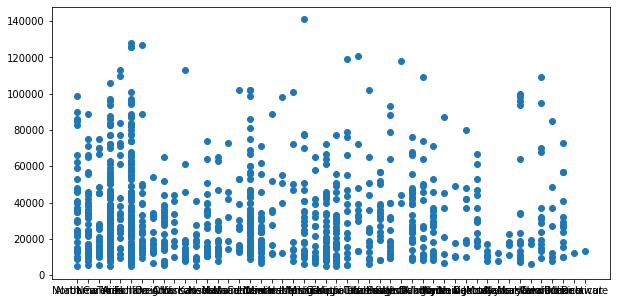

In [5]:
fig,ax=plt.subplots(figsize=(10,5))
ax.scatter(df["state"][:1000],df["SalePrice"][:1000]);

In [6]:
#getting the first 10000 sale date to view format 
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

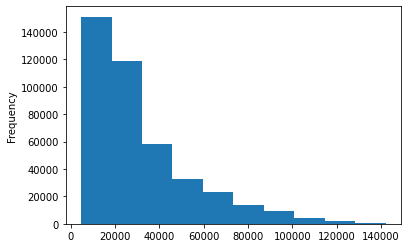

In [7]:
#Checking the distribution of our target variable through a histogram plot
df.SalePrice.plot.hist();

Most of the sale prices are between 200000-600000

### Parsing dates

When we work with time series data, we want to enrich the time  & date  component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the parse_dates parameter.

In [8]:
#Import data again bu this time parse dates
df=pd.read_csv('../input/bluebook-for-bulldozers/TrainAndValid.csv',
              low_memory=False,
              parse_dates=["saledate"])

In [9]:
#Getting the data type of our Saledate column after parsing dates
df.saledate.dtype

dtype('<M8[ns]')

**Tip from the Sale Date data type**

datetime64[ns] is a general dtype, while <M8[ns] is a specific dtype. 
General dtypes map to specific dtypes, but may be different from one installation of NumPy to the next.

source: stakeoverflow : https://stackoverflow.com/questions/29206612/difference-between-data-type-datetime64ns-and-m8ns

In [10]:
#Note the difference now in Saledate format after parse_dates
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

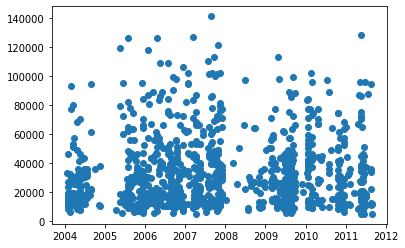

In [11]:
#plotting bulldozer sale dates in relation to their Sale Prices
fig,ax=plt.subplots()
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000]);


In [12]:
#Year with majority of sales
df.saledate.value_counts().sort_values(ascending=False)

2009-02-16    1932
2012-02-13    1598
2011-02-15    1352
2008-02-19    1300
2010-02-15    1219
              ... 
2006-08-08       1
2009-04-14       1
2009-11-16       1
2009-05-25       1
1997-10-11       1
Name: saledate, Length: 4013, dtype: int64

February is the month with the most sales from 2008-2012 with ,february 2009 having the highest sales.

In [13]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Sort DataFrame by saledate

When working with time series data,it's a good idea to sort it by date.

In [14]:
#sort DataFrame in date order
df.sort_values(by=["saledate"],inplace=True,ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make copy of the original DataFrame
We make a copy of the original dataframe so when we manipulate the copy ,we've still got our original data.

In [15]:
#make a copy
df_tmp=df.copy()

In [16]:
### sort bulldozer  Year make in ascending order
df.sort_values(by=["YearMade"],ascending=True)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
409203,6283635,34000.0,1869284,4701,149,99.0,1000,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
217641,1683717,28000.0,1269881,15044,132,1.0,1000,NaN,NaN,2005-06-23,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
278930,1852182,30000.0,636741,18649,132,1.0,1000,NaN,NaN,2005-06-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241040,1745533,8500.0,1469249,5357,132,1.0,1000,NaN,NaN,2005-06-23,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
215804,1680603,12500.0,1344753,11653,132,1.0,1000,NaN,NaN,2005-06-23,...,None or Unspecified,None or Unspecified,Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397847,6287738,70000.0,1877958,22156,149,2.0,2011,NaN,NaN,2011-10-03,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN
295706,2226857,35000.0,40066,4125,136,1.0,2012,4534.0,Low,2010-05-06,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
395524,6275685,55000.0,156521,1453,149,1.0,2013,NaN,NaN,2011-12-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
410474,6294577,34000.0,1845767,11742,149,0.0,2014,NaN,NaN,2012-03-22,...,None or Unspecified,None or Unspecified,Manual,None or Unspecified,Triple,NaN,NaN,NaN,NaN,NaN


In [17]:
### Sorting bulldozer prices in ascending
df.sort_values(by=["SalePrice","YearMade"],ascending=True)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
259011,1792322,4750.0,1521982,9548,132,7.0,1000,NaN,NaN,1994-03-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257496,1788936,4750.0,827054,9573,132,99.0,1000,NaN,NaN,1994-12-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27499,1256281,4750.0,1121889,3108,132,10.0,1000,NaN,NaN,1995-12-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258718,1791442,4750.0,1396287,9573,132,23.0,1000,NaN,NaN,1996-10-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164563,1587791,4750.0,1321392,7946,132,2.0,1000,NaN,NaN,1997-02-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124803,1470232,142000.0,1178561,3372,132,2.0,1996,NaN,NaN,2001-02-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124806,1470274,142000.0,511258,3372,132,2.0,1997,NaN,NaN,2004-04-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4878,1155699,142000.0,790302,23929,121,3.0,2005,1558.0,Medium,2007-10-25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22900,1218767,142000.0,556175,23931,121,3.0,2005,4306.0,Medium,2011-09-29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add dataframe parameters for saledate column

In [18]:
#this part of feature engineering
df_tmp["saleYear"]=df_tmp.saledate.dt.year
df_tmp["saleMonth"]=df_tmp.saledate.dt.month
df_tmp["saleDay"]=df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"]=df_tmp.saledate.dt.dayofweek
df_tmp["saleDayofYear"]=df_tmp.saledate.dt.dayofyear


In [19]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [20]:
#Now we've enriched our DataFrame with datetime features we can remove saledate column
df_tmp.drop("saledate",axis=1,inplace=True)

In [21]:
#Check the values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [22]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayofYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


## 5.Modelling

we've done enough EDA(we could always do more)but let's start to do some model-driven EDA.

In [23]:
#Let's build a machine learning model.
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor(n_jobs=1,
                           random_state=42)

#model.fit(df_tmp.drop("SalePrice",axis=1),df_tmp["SalePrice"])

In [24]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

In [25]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Convert strings to categories

One way we can turn all of our data into numbers is by converting them into pandas categories.

In [26]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [27]:
#Find the columns which contains strings
for label,content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)
    

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [28]:
#This will turn all the string values into category values.
for label,content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label]=content.astype("category").cat.as_ordered()

In [29]:
df_tmp.dtypes

SalesID                        int64
SalePrice                    float64
MachineID                      int64
ModelID                        int64
datasource                     int64
auctioneerID                 float64
YearMade                       int64
MachineHoursCurrentMeter     float64
UsageBand                   category
fiModelDesc                 category
fiBaseModel                 category
fiSecondaryDesc             category
fiModelSeries               category
fiModelDescriptor           category
ProductSize                 category
fiProductClassDesc          category
state                       category
ProductGroup                category
ProductGroupDesc            category
Drive_System                category
Enclosure                   category
Forks                       category
Pad_Type                    category
Ride_Control                category
Stick                       category
Transmission                category
Turbocharged                category
B

In [30]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [31]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas Categories we now have a way to access all of our data in the form of numbers.

More on this can be found here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html

But we still have a bunch of missing data.

In [32]:
#Check for mssing data
df_tmp.isna().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed data

In [33]:
#Export current tmp dataframe localy to pc
df_tmp.to_csv(r"D:\DS\bulldozer-price-prediction-project\data\bluebook-for-bulldozers\train_temp.csv",index=False)


In [34]:
#Import preprocessed data from pc
df_tmp=pd.read_csv(r"D:\DS\bulldozer-price-prediction-project\data\bluebook-for-bulldozers\train_temp.csv",
             low_memory=False)

In [35]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [36]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

## Fill missing values

#### Fill numeric missing values First

In [37]:
#check for numeric data types from our data set
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print (label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayofYear


In [38]:
#Check for which numeric columns have null values
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [39]:
#Fill numeric rows with the median
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            #Add a binary column which tells us if the data was missing or not
            df_tmp[label+"_is_missing"]=pd.isnull(content)
            #Fill missing numeric values with median
            df_tmp[label]=content.fillna(content.median())

median is more robust than mean to outliers.

In [40]:
#Check if there's any numeric values
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [41]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

In [42]:
#Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

### Filling and turning categorical variables into numbers

In [43]:
#check for columns which aren't numeric
for label,content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [44]:
#Turn categorical values into number and fill missing
for label,content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        #Add binary column to indicate whether sample had missing  value or not
        df_tmp[label+"_is_missing"]=pd.isnull(content)
        #Turn categories into numbers and add +1(we add +1 to give missing values 0 instead of -1)
        df_tmp[label]=pd.Categorical(content).codes+1

In [45]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [46]:
pd.Categorical(df_tmp["state"]).codes+1

array([44,  9,  9, ...,  5,  5,  5], dtype=int8)

Now that all of our data is numeric as well our data frame has no missing values we should be able to build a machine learning model.

In [47]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


# Building a machine learning model.

In [48]:
%%time 
#this calculates how much time this row gets to execute the code

#instantiate model
model=RandomForestRegressor(n_jobs=-1,
                           random_state=42)

#fit the model
model.fit(df_tmp.drop("SalePrice",axis=1),df_tmp["SalePrice"])

CPU times: user 21min 4s, sys: 3.77 s, total: 21min 8s
Wall time: 5min 27s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [49]:
#Score the model
model.score(df_tmp.drop("SalePrice",axis=1),df_tmp["SalePrice"])

0.9875468079970562

The data was tested on data it already knew about training data instead of test data (data that it's not seen) .This is why this metric is not reliable.

## Splitting train/validation sets

In [50]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [51]:
#Split data into training and validation
df_val=df_tmp[df_tmp.saleYear==2012]
df_train=df_tmp[df_tmp.saleYear != 2012]

len(df_val),len(df_train)

(11573, 401125)

In [52]:

# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an evaluation function

In [53]:
#Create  evaluation function (the competion uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Caculates root mean squared log error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

## Testing our model on a subset (to tune the hyperparameters)

In [54]:
#Change max_samples value in our Random Forest model
model=RandomForestRegressor(n_jobs=-1,
                           random_state=42,
                           max_samples=10000)
model

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [55]:
%%time 
#cutting down on the max number of samples each estimator can see improves training time
#currently using 10,0000 instead of 401125
model.fit(X_train,y_train)

CPU times: user 44.5 s, sys: 722 ms, total: 45.2 s
Wall time: 15.4 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [56]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

# Hyperparameter tuning with RandomizedSearchCV

In [57]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=5,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.6min finished


CPU times: user 2min 21s, sys: 15.3 s, total: 2min 36s
Wall time: 2min 45s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [58]:
#Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 50,
 'min_samples_split': 4,
 'min_samples_leaf': 7,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': 10}

In [59]:
#Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 7000.942462436125,
 'Valid MAE': 8187.154373210765,
 'Training RMSLE': 0.31078656998627446,
 'Valid RMSLE': 0.3301316069894979,
 'Training R^2': 0.7906110903528817,
 'Valid R^2': 0.7877252185960579}

## Train a model with the best hyperparameter

**Note** These were found after 100 iterations of RandomizedSearchCV

In [60]:
%%time
#Most ideal hyperparameters
ideal_model=RandomForestRegressor(n_estimators=40,
                                 min_samples_leaf=1,
                                 min_samples_split=14,
                                 max_features=0.5,
                                 n_jobs=-1,
                                 max_samples=None,
                                 random_state=42) #random state so that our results are reproducible
#Fit the ideal model
ideal_model.fit(X_train,y_train)

CPU times: user 3min 50s, sys: 2.64 s, total: 3min 53s
Wall time: 1min 5s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [61]:
#scores for ideal model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.24524163989538328,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450094}

In [62]:
#scores on rs_model(only trained on -10,000 examples)
show_scores(rs_model)

{'Training MAE': 7000.942462436125,
 'Valid MAE': 8187.154373210765,
 'Training RMSLE': 0.31078656998627446,
 'Valid RMSLE': 0.3301316069894979,
 'Training R^2': 0.7906110903528817,
 'Valid R^2': 0.7877252185960579}

## Make predictions on test data

In [63]:
#import the test data
df_test=pd.read_csv('../input/bluebook-for-bulldozers/Test.csv',
                   low_memory=False,
                   parse_dates=["saledate"])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


# Preprocessing test data

In [64]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df."""
    df["saleYear"]=df.saledate.dt.year
    df["saleMonth"]=df.saledate.dt.month
    df["saleDay"]=df.saledate.dt.day
    df["saleDayOfWeek"]=df.saledate.dt.dayofweek
    df["saleDayofYear"]=df.saledate.dt.dayofyear

    df.drop("saledate",axis=1, inplace=True)
    #Fill the numeric rows with median
    for label,content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                #Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"]=pd.isnull(content)
                #Fill missing numeric values with median
                df[label]=content.fillna(content.median())
    
        #Filled categorical missing data and turn categories into numbers
    
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"]=pd.isnull(content)
                #We add +1 to the category code because pandas encodes missing categories as -1
            df[label]=pd.Categorical(content).codes+1
    return df

In [65]:
#Process test data
df_test=preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [66]:
#We can find how the columns differ using sets
set(X_train.columns)-set(df_test.columns)

{'auctioneerID_is_missing'}

In [67]:
#Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"]=False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


Finally now our test dataframe has the same features as our training dataframe.We can now make predictions!

# Make predictions using test data

In [68]:
#Make predictions on updated test data
test_preds=ideal_model.predict(df_test)

In [69]:
test_preds

array([20614.36780887, 19897.80170658, 44852.21959446, ...,
       14296.98620472, 22164.85757662, 31683.80063427])

We've have made the predictions but they are not in the same format kaggle is asking for:
https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [70]:
#Format predictions into the same format Kaggle is after
df_preds=pd.DataFrame()
df_preds["SalesID"]=df_test["SalesID"]
df_preds["SalesPrice"]=test_preds
df_preds

,SalesID,SalesPrice
0,1227829,20614.367809
1,1227844,19897.801707
2,1227847,44852.219594
3,1227848,68346.325323
4,1227863,39487.349708
...,...,...
12452,6643171,46466.092910
12453,6643173,17500.493352
12454,6643184,14296.986205
12455,6643186,22164.857577


In [71]:
#Export prediction data
df_preds.to_csv(r"D:\DS\bulldozer-price-prediction-project\data\bluebook-for-bulldozers\test_predictions.csv",index=False)

# Feature Importance

Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting **target variable**(SalePrice).


In [72]:
#Find feature importance of our best model
ideal_model.feature_importances_

array([3.39445533e-02, 1.81148281e-02, 4.09167072e-02, 1.70752171e-03,
       3.40797459e-03, 2.08200698e-01, 2.95067052e-03, 1.10113725e-03,
       4.16122668e-02, 4.71911805e-02, 6.23815431e-02, 4.67433955e-03,
       1.52524442e-02, 1.52517337e-01, 4.72224713e-02, 5.96817956e-03,
       1.29351899e-03, 2.78088439e-03, 2.37248769e-03, 6.17114453e-02,
       8.13525488e-04, 3.61873268e-05, 9.19098115e-04, 2.23170993e-04,
       1.28102678e-03, 2.06519636e-05, 2.01477316e-03, 6.63364759e-03,
       2.15274492e-03, 2.50178165e-03, 4.63902393e-03, 3.85873985e-03,
       2.76062667e-03, 1.00782454e-03, 2.47969268e-04, 6.04239818e-03,
       7.64997072e-04, 1.57100537e-02, 2.29716203e-03, 2.58372272e-03,
       8.07637426e-04, 9.18548690e-04, 1.35656446e-03, 5.81458569e-04,
       4.96716928e-04, 3.79552257e-04, 5.31712788e-04, 2.71823509e-03,
       8.34294376e-04, 3.12136841e-04, 2.14075157e-04, 7.42422919e-02,
       3.80158492e-03, 5.67641024e-03, 2.87154703e-03, 9.83349904e-03,
      

In [73]:
#Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()


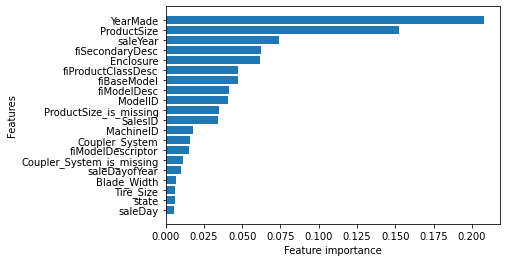

In [74]:
plot_features(X_train.columns, ideal_model.feature_importances_)



# XGBoost Regressor Model



In [75]:
#using XGboost Regression model to improve our rmsle
from xgboost import XGBRegressor
#instantiate our xgboost model
xgbr_model=XGBRegressor(n_estimators=1000,
                      learning_rate=0.05,
                      max_depth=8,
                      random_state=42)

#using the model to fit on our training data
xgbr_model.fit(X_train,y_train)
xgbr_preds=xgbr_model.predict(X_valid)

In [76]:
xgbr_score=r2_score(y_valid,xgbr_preds)
xgbr_score

0.8845271215217702

In [77]:
#getting the rmsle as its the evaluation metric 
np.sqrt(mean_squared_log_error(y_valid,xgbr_preds))

0.2443551989377156

In [78]:
xgbr_test_preds=xgbr_model.predict(df_test)

In [79]:
xgbr_test_preds

array([20405.895, 18165.016, 51925.234, ..., 10979.251,  9653.119,
       24463.762], dtype=float32)

In [80]:
#Format predictions into the same format Kaggle is after
df_preds=pd.DataFrame()
df_preds["SalesID"]=df_test["SalesID"]
df_preds["SalesPrice"]=xgbr_test_preds
df_preds

,SalesID,SalesPrice
0,1227829,20405.894531
1,1227844,18165.015625
2,1227847,51925.234375
3,1227848,75197.070312
4,1227863,44797.507812
...,...,...
12452,6643171,35483.320312
12453,6643173,8014.323242
12454,6643184,10979.250977
12455,6643186,9653.119141


In [81]:
#Export prediction data to local pc
df_preds.to_csv(r"D:\DS\bulldozer-price-prediction-project\data\bluebook-for-bulldozers\test_predictions.csv",index=False)

In [82]:
xgbr_model.feature_importances_

array([2.47798045e-03, 1.55967730e-03, 5.22442581e-03, 1.20515760e-03,
       6.63118495e-04, 3.08269896e-02, 7.16250099e-04, 1.78550673e-03,
       4.01923899e-03, 7.85182714e-02, 2.32871566e-02, 3.81674478e-03,
       7.82855507e-03, 1.07412018e-01, 1.14171235e-02, 6.05213339e-04,
       1.52395926e-02, 0.00000000e+00, 7.64092989e-03, 4.93548624e-02,
       7.94790860e-04, 1.25943555e-03, 4.86588152e-03, 2.27543130e-03,
       4.40708594e-03, 2.24320611e-04, 9.26017687e-02, 7.27263242e-02,
       1.12308585e-03, 6.72996684e-04, 1.15110744e-02, 8.93962383e-03,
       7.74129992e-03, 3.88083421e-02, 1.32458936e-03, 6.52465969e-03,
       1.66711898e-03, 3.16132456e-01, 1.74086895e-02, 6.93402113e-03,
       8.10304843e-03, 1.52924610e-03, 9.35440301e-04, 9.32753726e-04,
       1.51813775e-03, 1.00942398e-03, 8.06990173e-03, 2.72334157e-03,
       3.13423760e-03, 1.73106126e-03, 3.51136108e-03, 1.11114690e-02,
       3.67317756e-04, 4.36511240e-04, 4.91409679e-04, 1.30970858e-03,
      

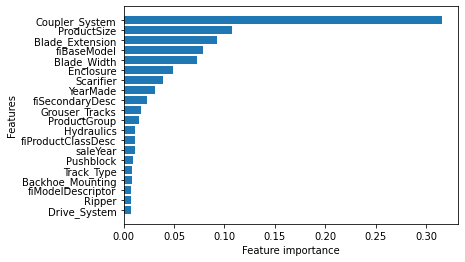

In [83]:
plot_features(X_train.columns, xgbr_model.feature_importances_)

The above graph shows the important features worth concidering for bulldozer house predictions based on test data.

#  Conclusion
Using XGBoost Regressor algorithm gave a slight improvement to our ideal Random Forest Regressor model from the evaluation metric used.